# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="./Tennis_Linux/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
env_action_size = brain.vector_action_space_size
print('Size of each action:', env_action_size)

# examine the state space 
states = env_info.vector_observations
env_state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], env_state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [19]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, env_action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
# Imports
import random
import torch

import os
import numpy as np
from collections import deque
import time
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

# Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")

# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'
 

In [7]:
UPDATE_EVERY_NB_EPISODE = 4        # Nb of episodes between learning process
MULTIPLE_LEARN_PER_UPDATE = 3      # Nb of multiple learning process performed in a row

BUFFER_SIZE = int(1e5)             # replay buffer size
BATCH_SIZE = 256                   # minibatch size

FA1_UNITS = 128  #256        # Number of units for the layer 1 in the actor model
FA2_UNITS = 128  #128        # Number of units for the layer 2 in the actor model
FC1_UNITS = 128  #256      # Number of units for the layer 1 in the critic model
FC2_UNITS = 128  #128       # Number of units for the layer 2 in the critic model
LR_ACTOR = 2e-4    #1e-4           # learning rate of the actor 
LR_CRITIC = 2e-4   #2e-3           # learning rate of the critic
WEIGHT_DECAY = 0   #0.0001         # L2 weight decay

GAMMA = 0.99 #0.995                # Discount factor
TAU = 1e-3                         # For soft update of target parameters
CLIP_CRITIC_GRADIENT = False       # Clip gradient during Critic optimization

MU = 0.                            # Ornstein-Uhlenbeck noise parameter
THETA = 0.15                       # Ornstein-Uhlenbeck noise parameter
SIGMA = 0.1                        # Ornstein-Uhlenbeck noise parameter
NOISE = 1.0                        # Initial Noise Amplitude 
NOISE_REDUCTION = 1.0 # 0.995      # Noise amplitude decay ratio

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fa1_units=400, fa2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fa1_units)
        self.fc2 = nn.Linear(fa1_units, fa2_units)
        self.fc3 = nn.Linear(fa2_units, action_size)
        
        self.bn1 = nn.BatchNorm1d(fa1_units)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        
        x = F.relu(self.fc1(state))
        
        x = self.bn1(x) 
            
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.bn1 = nn.BatchNorm1d(fc1_units)
            
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs) 
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)



In [9]:
import numpy as np
import random
import copy
from collections import namedtuple, deque



import torch
import torch.nn.functional as F
import torch.optim as optim



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, num_agents, fa1_units=FA1_UNITS, fa2_units=FA2_UNITS, 
                  fc1_units=FC1_UNITS, fc2_units=FC2_UNITS,
                BUFFER_SIZE_=BUFFER_SIZE, BATCH_SIZE_=BATCH_SIZE, GAMMA_=GAMMA, TAU_=TAU, LR_ACTOR_=LR_ACTOR, 
                 LR_CRITIC_=LR_CRITIC, WEIGHT_DECAY_= WEIGHT_DECAY,
                mu_=MU, theta_=THETA, sigma_=SIGMA):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.num_agents = num_agents
        
        self.batch_size = BATCH_SIZE_
        self.gamma_ = GAMMA_
        self.tau_ = TAU_

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed, fa1_units, fa2_units).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, fa1_units, fa2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR_)
        
        # Make sure the Target Network has the same weight values as the Local Network
        for target, local in zip(self.actor_target.parameters(), self.actor_local.parameters()):
            target.data.copy_(local.data)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size*self.num_agents, action_size*self.num_agents, random_seed,fc1_units, fc2_units).to(device)
        self.critic_target = Critic(state_size*self.num_agents, action_size*self.num_agents, random_seed,fc1_units, fc2_units).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC_, weight_decay=WEIGHT_DECAY)
        
        # Make sure the Target Network has the same weight values as the Local Network
        for target, local in zip(self.critic_target.parameters(), self.critic_local.parameters()):
            target.data.copy_(local.data)

        # Noise process
        self.noise = OUNoise(action_size, random_seed, mu=mu_, theta=theta_, sigma=sigma_)

        # Replay memory
        #self.memory = ReplayBuffer(action_size, BUFFER_SIZE_, self.batch_size, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma_)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau_)
        self.soft_update(self.actor_local, self.actor_target, self.tau_)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size=size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size) # use normal distribution
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [10]:
import numpy as np
import torch

# Helper functions to concatenate/extract multipe agents states/actions for use with the Replay Buffer memory.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def encode(sa):
    """
    Encode an Environment state or action list of array, which contain multiple agents action/state information, 
    by concatenating their information, thus removing (but not loosing) the agent dimension in the final output. 
    
    The ouput is a list intended to be inserted into a buffer memmory originally not designed to handle multiple 
    agents information, such as in the context of MADDPG)
    
    Params
    ======       
            sa (listr) : List of Environment states or actions array, corresponding to each agent
                
    """
    return np.array(sa).reshape(1,-1).squeeze()



def decode(size, num_agents, id_agent, sa, debug=False):
    """
    Decode a batch of Environment states or actions, which have been previously concatened to store 
    multiple agent information into a buffer memmory originally not designed to handle multiple 
    agents information(such as in the context of MADDPG)
    
    This returns a batch of Environment states or actions (torch.tensor) containing the data 
    of only the agent specified.
    
    Params
    ======
            size (int): size of the action space of state spaec to decode
            num_agents (int) : Number of agent in the environment (and for which info hasbeen concatenetaded)
            id_agent (int): index of the agent whose informationis going to be retrieved
            sa (torch.tensor) : Batch of Environment states or actions, each concatenating the info of several 
                                agents (This is sampled from the buffer memmory in the context of MADDPG)
            debug (boolean) : print debug information
    
    """
    
    list_indices  = torch.tensor([ idx for idx in range(id_agent * size, id_agent * size + size) ]).to(device)    
    out = sa.index_select(1, list_indices)
   
    if (debug):
        print("\nDebug decode:\n size=",size, " num_agents=", num_agents, " id_agent=", id_agent, "\n")
        print("input:\n", sa,"\n output:\n",out,"\n\n\n")
    return  out



In [11]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Maddpg():
    """MADDPG Agent : Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize a MADDPG Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): number of agents
            random_seed (int): random seed
        """
        
        super(Maddpg, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        
        # Instantiate Multiple  Agent
        self.agents = [ Agent(state_size,action_size, random_seed, num_agents) 
                       for i in range(num_agents) ]
        
        # Instantiate Memory replay Buffer (shared between agents)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
                  
    def reset(self):
        """Reset all the agents"""
        for agent in self.agents:
            agent.reset()

    def act(self, states):
        """Return action to perform for each agents (per policy)"""        
        return [ agent.act(state) for agent, state in zip(self.agents, states) ]
                
    
    def step(self, states, actions, rewards, next_states, dones, num_current_episode):
        """ # Save experience in replay memory, and use random sample from buffer to learn"""
 
        #self.memory.add(states, It mainly reuse function from ``actions, rewards, next_states, dones)
        self.memory.add(encode(states), 
                        encode(actions), 
                        rewards,
                        encode(next_states),
                        dones)

        # If enough samples in the replay memory and if it is time to update
        if (len(self.memory) > BATCH_SIZE) and (num_current_episode % UPDATE_EVERY_NB_EPISODE ==0) :
            
            # Note: this code only expects 2 agents
            assert(len(self.agents)==self.num_agents)
            
            # Allow to learn several time in a row in the same episode
            for i in range(MULTIPLE_LEARN_PER_UPDATE):
                # Sample a batch of experience from the replay buffer 
                experiences = self.memory.sample()   
                # Update Agent #0
                self.maddpg_learn(experiences, own_idx=0, other_idx=1)
                # Sample another batch of experience from the replay buffer 
                experiences = self.memory.sample()   
                # Update Agent #1
                self.maddpg_learn(experiences, own_idx=1, other_idx=0)
                
    
    def maddpg_learn(self, experiences, own_idx, other_idx, gamma=GAMMA):
        """
        Update the policy of the MADDPG "own" agent. The actors have only access to agent own 
        information, whereas the critics have access to all agents information.
        
        Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(states) -> action
            critic_target(all_states, all_actions) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            own_idx (int) : index of the own agent to update in self.agents
            other_idx (int) : index of the other agent to update in self.agents
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences
               
        # Filter out the agent OWN states, actions and next_states batch
        own_states =  decode(self.state_size, self.num_agents, own_idx, states)
        own_actions = decode(self.action_size, self.num_agents, own_idx, actions)
        own_next_states = decode(self.state_size, self.num_agents, own_idx, next_states) 
                
        # Filter out the OTHER agent states, actions and next_states batch
        other_states =  decode(self.state_size, self.num_agents, other_idx, states)
        other_actions = decode(self.action_size, self.num_agents, other_idx, actions)
        other_next_states = decode(self.state_size, self.num_agents, other_idx, next_states)
        
        # Concatenate both agent information (own agent first, other agent in second position)
        all_states=torch.cat((own_states, other_states), dim=1).to(device)
        all_actions=torch.cat((own_actions, other_actions), dim=1).to(device)
        all_next_states=torch.cat((own_next_states, other_next_states), dim=1).to(device)
   
        agent = self.agents[own_idx]
   
        own_rewards = rewards[:, own_idx]
        own_dones = dones[:, own_idx]
        
        
        
            
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models        
        all_next_actions = torch.cat((agent.actor_target(own_states), agent.actor_target(other_states)),
                                     dim =1).to(device) 
        Q_targets_next = agent.critic_target(all_next_states, all_next_actions)
        
        
        # Compute Q targets for current states (y_i)
        Q_targets = own_rewards.view(-1, 1) + (gamma * Q_targets_next * (1 - own_dones.view(-1, 1)))
        
        
        # Compute critic loss
        Q_expected = agent.critic_local(all_states, all_actions)
        
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        agent.critic_optimizer.zero_grad()
        critic_loss.backward()
        if (CLIP_CRITIC_GRADIENT):
            torch.nn.utils.clip_grad_norm(agent.critic_local.parameters(), 1)
        agent.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        all_actions_pred = torch.cat((agent.actor_local(own_states), agent.actor_local(other_states).detach()),
                                     dim = 1).to(device)      
        actor_loss = -agent.critic_local(all_states, all_actions_pred).mean()
        
        # Minimize the loss
        agent.actor_optimizer.zero_grad()
        actor_loss.backward()        
        agent.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        agent.soft_update(agent.critic_local, agent.critic_target, TAU)
        agent.soft_update(agent.actor_local, agent.actor_target, TAU)                   
    
    
                        
    def save_checkpoints(self, name=""):
        """Save checkpoints for all Agents"""
        for idx, agent in enumerate(self.agents):
            actor_local_filename = 'checkpoint_actor_local_' +str(name)+"_"+ str(idx) + '.pth'
            critic_local_filename = 'checkpoint_critic_local_' +str(name)+"_"+ str(idx) + '.pth'           
            actor_target_filename = 'checkpoint_actor_target_' +str(name)+"_"+ str(idx) + '.pth'
            critic_target_filename = 'checkpoint_critic_target_' +str(name)+"_"+ str(idx) + '.pth'            
            torch.save(agent.actor_local.state_dict(), actor_local_filename) 
            torch.save(agent.critic_local.state_dict(), critic_local_filename)             
            torch.save(agent.actor_target.state_dict(), actor_target_filename) 
            torch.save(agent.critic_target.state_dict(), critic_target_filename)
            
            
    

In [12]:
def maddpg_train(n_episodes=10000, max_t=1000, print_every=100, random_seed=10, nameModel = ""):  
    
    # Seeding
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Instantiate the MADDPG agents
    maddpg = Maddpg(env_state_size, env_action_size, num_agents, random_seed)

    # Monitor the score    
    scores_deque = deque(maxlen=print_every)
    all_scores = []
    all_avg_score = []
    
    
    # Training Loop
    for i_episode in range(n_episodes+1):  
             
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment  
        maddpg.reset()                                             # reset the agents 
            
        states = env_info.vector_observations                      # get the current state for each agent 
        scores = np.zeros(num_agents)                              # initialize the score (for each agent)

        for steps in range(max_t):

            actions = maddpg.act(states)                    # retrieve actions to performe for each agents
            env_info = env.step(actions)[brain_name]               # send all actions to tne environment
            next_states = env_info.vector_observations             # get next state for each agent
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            
            # Save experience in replay memory, and use random sample from buffer to learn
            maddpg.step(states, actions, rewards, next_states, dones, i_episode)  

            scores += env_info.rewards                             # update the score (for each agent)
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                      # exit loop if episode finished
                break
        
        # Save scores and compute average score over last n episodes       
        episode_score  = np.max(scores)  # Consider the maximum score amongs all Agents
        all_scores.append(episode_score)
        scores_deque.append(episode_score)
        avg_score = np.mean(scores_deque)

        # Display statistics 
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpisode score (max over agents): {:.2f}'.format(i_episode, avg_score, episode_score), end="")
        if i_episode>0 and i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} '.format(i_episode, avg_score))
            maddpg.save_checkpoints(nameModel)
            all_avg_score.append(avg_score)
        
        # Early stop
        if (i_episode>print_every-1) and (avg_score >=0.5):
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
            maddpg.save_checkpoints(nameModel)
            return all_scores

    return all_scores


In [13]:
def plot_training(scores):
    # Plot the Score evolution during the training
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='deepskyblue')
    ax.tick_params(axis='y', colors='deepskyblue')
    plt.plot(np.arange(1, len(scores)+1), scores, color='deepskyblue')
    plt.ylabel('Score', color='deepskyblue')
    plt.xlabel('Episode #', color='deepskyblue')
    plt.show()

Episode 100	Average Score: 0.00 (nb of total steps=1485   noise=1.0000)
Episode 200	Average Score: 0.01 (nb of total steps=3082   noise=1.0000)
Episode 300	Average Score: 0.00 (nb of total steps=4552   noise=1.0000)
Episode 400	Average Score: 0.00 (nb of total steps=5972   noise=1.0000)
Episode 500	Average Score: 0.00 (nb of total steps=7441   noise=1.0000)
Episode 600	Average Score: 0.01 (nb of total steps=8987   noise=1.0000)
Episode 700	Average Score: 0.00 (nb of total steps=10425   noise=1.0000)
Episode 800	Average Score: 0.00 (nb of total steps=11844   noise=1.0000)
Episode 900	Average Score: 0.01 (nb of total steps=13498   noise=1.0000)
Episode 1000	Average Score: 0.02 (nb of total steps=15379   noise=1.0000)
Episode 1100	Average Score: 0.04 (nb of total steps=17570   noise=1.0000)
Episode 1200	Average Score: 0.04 (nb of total steps=19755   noise=1.0000)
Episode 1300	Average Score: 0.04 (nb of total steps=21992   noise=1.0000)
Episode 1400	Average Score: 0.04 (nb of total steps=2

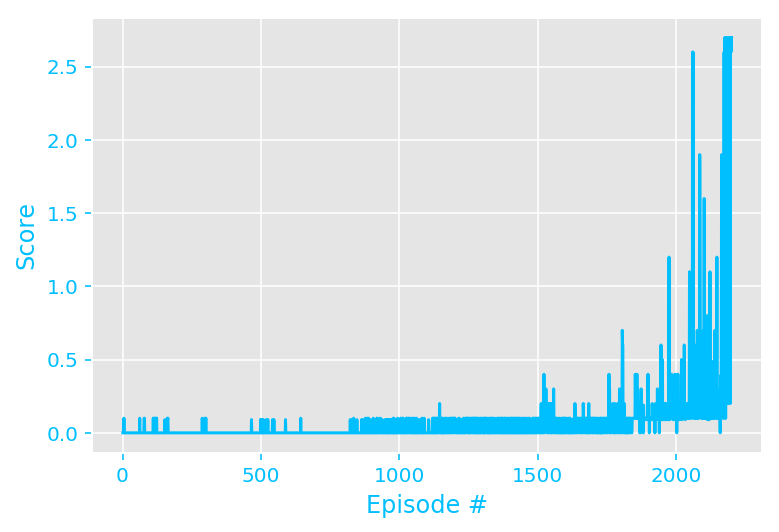

In [155]:
import torch.nn.functional as F

# Default hyperparameters
                           
UPDATE_EVERY_NB_EPISODE = 4        # Nb of episodes between learning process
MULTIPLE_LEARN_PER_UPDATE = 3      # Nb of multiple learning process performed in a row

BUFFER_SIZE = int(1e5)             # replay buffer size
BATCH_SIZE = 256                   # minibatch size

FA1_UNITS = 128  #256        # Number of units for the layer 1 in the actor model
FA2_UNITS = 128  #128        # Number of units for the layer 2 in the actor model
FC1_UNITS = 128  #256      # Number of units for the layer 1 in the critic model
FC2_UNITS = 128  #128       # Number of units for the layer 2 in the critic model
LR_ACTOR = 2e-4    #1e-4           # learning rate of the actor 
LR_CRITIC = 2e-4   #2e-3           # learning rate of the critic
WEIGHT_DECAY = 0   #0.0001         # L2 weight decay

GAMMA = 0.99 #0.995                # Discount factor
TAU = 1e-3                         # For soft update of target parameters
CLIP_CRITIC_GRADIENT = False       # Clip gradient during Critic optimization

MU = 0.                            # Ornstein-Uhlenbeck noise parameter
THETA = 0.15                       # Ornstein-Uhlenbeck noise parameter
SIGMA = 0.1                        # Ornstein-Uhlenbeck noise parameter
NOISE = 1.0                        # Initial Noise Amplitude 
NOISE_REDUCTION = 1.0 # 0.995      # Noise amplitude decay ratio


scores = maddpg_train(n_episodes=3000, max_t=1000, print_every=100, random_seed=10)
plot_training(scores)

Episode 100	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 200	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 300	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 400	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 500	Average Score: 0.01 Episode score (max over agents): 0.10
Episode 600	Average Score: 0.02 Episode score (max over agents): 0.00
Episode 700	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 800	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 900	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 1000	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 1100	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 1200	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 1300	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 1400	Average Score: 0.00 Episode score (max over agents): 0.00
Episode 1500	Av

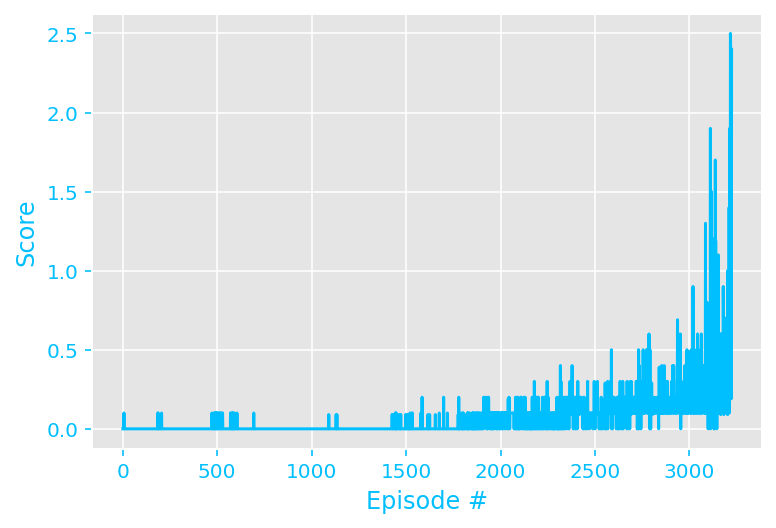

In [22]:
import torch.nn.functional as F

# Default hyperparameters
                           
UPDATE_EVERY_NB_EPISODE = 4        # Nb of episodes between learning process
MULTIPLE_LEARN_PER_UPDATE = 3      # Nb of multiple learning process performed in a row

BUFFER_SIZE = int(1e5)             # replay buffer size
BATCH_SIZE = 256                   # minibatch size

FA1_UNITS = 128  #256        # Number of units for the layer 1 in the actor model
FA2_UNITS = 128  #128        # Number of units for the layer 2 in the actor model
FC1_UNITS = 128  #256      # Number of units for the layer 1 in the critic model
FC2_UNITS = 128  #128       # Number of units for the layer 2 in the critic model
LR_ACTOR = 2e-4    #1e-4           # learning rate of the actor 
LR_CRITIC = 2e-4   #2e-3           # learning rate of the critic
WEIGHT_DECAY = 0   #0.0001         # L2 weight decay

GAMMA = 0.99 #0.995                # Discount factor
TAU = 1e-3                         # For soft update of target parameters
CLIP_CRITIC_GRADIENT = False       # Clip gradient during Critic optimization

MU = 0.                            # Ornstein-Uhlenbeck noise parameter
THETA = 0.15                       # Ornstein-Uhlenbeck noise parameter
SIGMA = 0.1                        # Ornstein-Uhlenbeck noise parameter
NOISE = 1.0                        # Initial Noise Amplitude 
NOISE_REDUCTION = 1.0 # 0.995      # Noise amplitude decay ratio


scores = maddpg_train(n_episodes=3500, max_t=1000, print_every=100, random_seed=10, nameModel = "v2")
plot_training(scores)

In [16]:

maddpg = Maddpg(env_state_size, env_action_size, 2, 10)
for idx, agent in enumerate(maddpg.agents):
    actor_local_filename = 'checkpoint_actor_local_v2_'+ str(idx) + '.pth'
    critic_local_filename = 'checkpoint_critic_local_v2_'+ str(idx) + '.pth'  
    
    agent.actor_local.load_state_dict(torch.load(actor_local_filename))
    agent.critic_local.load_state_dict(torch.load(critic_local_filename))
            

In [21]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = maddpg.act(states) # select an action (for each agent)
        #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 1.5450000232085586
Total score (averaged over agents) this episode: 0.7450000112876296
Total score (averaged over agents) this episode: 0.44500000681728125
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: 0.19500000309199095
